# Lesson 2 : LangGraph Components

In [1]:
# !brew install graphviz
# export C_INCLUDE_PATH=$(brew --prefix graphviz)/include
# export LIBRARY_PATH=$(brew --prefix graphviz)/lib
# pip install pygraphviz

# get free Tavily key at https://app.tavily.com/sign-in and put in .env

In [2]:
from dotenv import load_dotenv
_ = load_dotenv()

In [3]:
import os
from typing import TypedDict, Annotated
import operator
from IPython.display import Image, display, HTML, Markdown

import openai

from langgraph.graph import StateGraph, END
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_openai import ChatOpenAI
from langchain.tools import BaseTool, StructuredTool, tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.aiosqlite import AsyncSqliteSaver
from langchain_core.pydantic_v1 import BaseModel, Field


import wikipedia


In [4]:
MODEL='gpt-4o'

DOWNLOAD_DIR = 'download'
OUTPUT_Dir = 'output'


# Simple prompt completion


In [9]:
model = ChatOpenAI(model=MODEL)

messages = [
    SystemMessage(content="Translate the following from English into French"),
    HumanMessage(content="Listen to me. You are beautiful. You are flawless and I love you."),
]

response = model.invoke(messages)

print(response.content)


Écoute-moi. Tu es belle. Tu es parfaite et je t'aime.


# With a prompt template


In [10]:
system_template = "Translate the following into {language}:"
user_template = "Listen to me. You are {adjective1}. You are {adjective2} and I love you."

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), 
     ("user", user_template)]
)

parser = StrOutputParser()

chain = prompt_template | model | parser

# stream tokens as they are generated
response = ""
for r in chain.stream({"language": "German", "adjective1": "tops", "adjective2": "amazing"}):
    print(r, end="")
    response += r

# response


Hör mir zu. Du bist spitze. Du bist erstaunlich und ich liebe dich.

# Using a graph and a tool

In [11]:
mytool = TavilySearchResults(max_results=4) #increased number of results
print(type(mytool))
print(mytool.name)


<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [12]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
        

In [13]:
memory = AsyncSqliteSaver.from_conn_string(":memory:")

class Agent:

    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(checkpointer=checkpointer)
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)
        
    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Sending tool results back to the model!")
        return {'messages': results}


In [14]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You can make multiple calls (either simultaneously or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model=MODEL)
lg_agent = Agent(model, [mytool], memory, system=prompt)


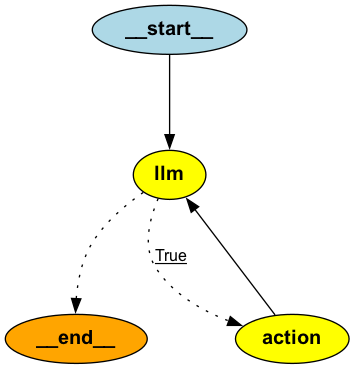

In [15]:
Image(lg_agent.graph.get_graph().draw_png())


In [16]:
messages = [HumanMessage(content="What is the current weather in Brooklyn and as of what time?")]
thread = {"configurable": {"thread_id": "1"}}
all_content=""
async for event in lg_agent.graph.astream_events({"messages": messages}, thread, version="v1"):
    kind = event["event"]
    if kind == "on_chat_model_stream":  # stream content
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="")
            all_content += content

display(Markdown("**Final result**"))

display(Markdown(all_content))


/opt/anaconda3/envs/langgraph/lib/python3.11/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: This API is in beta and may change in the future.
  warn_beta(


Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Brooklyn'}, 'id': 'call_UVcUjyEA5fRgnEMn8NDhJqYC'}
Sending tool results back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Brooklyn, NY'}, 'id': 'call_70Xilc7ivMuLGrKDlcJkHW9n'}
Sending tool results back to the model!
The current weather in Brooklyn, NY as of 1:30 PM on June 24, 2024, is 25.6°C (78.1°F) and overcast. The wind is coming from the west-northwest at 2.2 mph (3.6 kph). The humidity is at 42%, and visibility is 16 km (9 miles). The UV index is 7.

**Final result**

The current weather in Brooklyn, NY as of 1:30 PM on June 24, 2024, is 25.6°C (78.1°F) and overcast. The wind is coming from the west-northwest at 2.2 mph (3.6 kph). The humidity is at 42%, and visibility is 16 km (9 miles). The UV index is 7.

# Using 2 tools in parallel

In [18]:
messages = [HumanMessage(content="What is the weather in San Francisco, Eureka, and Denver? and as of what time")]
thread = {"configurable": {"thread_id": "2"}}
all_content=""
async for event in lg_agent.graph.astream_events({"messages": messages}, thread, version="v1"):
    kind = event["event"]
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="")
            all_content += content

display(Markdown(all_content))


Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_zlYP80w8gPtcGmo2st8lEqZK'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Eureka, California'}, 'id': 'call_k4jqShchNQJ1YI2TQGHs8EHp'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Denver, Colorado'}, 'id': 'call_QCIANLQzsE0TkhUdT951ez4R'}
Sending tool results back to the model!
### San Francisco
- **Current Temperature**: 17.2°C (63.0°F)
- **Condition**: Partly cloudy
- **Wind**: 11.9 mph (19.1 kph) from the NW
- **Humidity**: 67%
- **Visibility**: 16.0 km (9.0 miles)
- **Last Updated**: June 24, 2024, 10:30 AM local time

### Eureka, California
- **Current Temperature**: 13.3°C (55.9°F)
- **Condition**: Overcast
- **Wind**: 3.8 mph (6.1 kph) from the W
- **Humidity**: 77%
- **Visibility**: 16.0 km (9.0 miles)
- **Last Updated**: June 24, 2024, 10:30 AM local time

### Denver, Colorado
- **Curr

### San Francisco
- **Current Temperature**: 17.2°C (63.0°F)
- **Condition**: Partly cloudy
- **Wind**: 11.9 mph (19.1 kph) from the NW
- **Humidity**: 67%
- **Visibility**: 16.0 km (9.0 miles)
- **Last Updated**: June 24, 2024, 10:30 AM local time

### Eureka, California
- **Current Temperature**: 13.3°C (55.9°F)
- **Condition**: Overcast
- **Wind**: 3.8 mph (6.1 kph) from the W
- **Humidity**: 77%
- **Visibility**: 16.0 km (9.0 miles)
- **Last Updated**: June 24, 2024, 10:30 AM local time

### Denver, Colorado
- **Current Temperature**: 32.7°C (90.9°F)
- **Condition**: Partly cloudy
- **Wind**: 2.2 mph (3.6 kph) from the N
- **Humidity**: 13%
- **Visibility**: 16.0 km (9.0 miles)
- **Last Updated**: June 24, 2024, 11:30 AM local time

# 2 tools in sequence, where answer from 2nd depends on result from 1st

In [19]:
query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
Who are the statewide elected officials of that state? Answer each question." 
messages = [HumanMessage(content=query)]
thread = {"configurable": {"thread_id": "3"}}
all_content=""
async for event in lg_agent.graph.astream_events({"messages": messages}, thread, version="v1"):
    kind = event["event"]
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="")
            all_content += content

display(Markdown(all_content))


Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Super Bowl 2024 winner'}, 'id': 'call_BGFfSkZ8sqpAxdcVAK8XW7o5'}
Sending tool results back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters location'}, 'id': 'call_iUcpFmFPHcBZqtXVhvhP3s1Q'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current statewide elected officials of Missouri'}, 'id': 'call_S2BnaNcs4mqtxScwELkxJLfx'}
Sending tool results back to the model!
### Who won the Super Bowl in 2024?
The Kansas City Chiefs won the Super Bowl in 2024, defeating the San Francisco 49ers in overtime with a score of 25-22.

### In what state is the winning team headquarters located?
The Kansas City Chiefs are headquartered in Kansas City, Missouri. Their address is One Arrowhead Drive, Kansas City, MO 64129, USA.

### Who are the statewide elected officials of that state?
The statewide elected officials of Missouri include:

1. **Governor**: 

### Who won the Super Bowl in 2024?
The Kansas City Chiefs won the Super Bowl in 2024, defeating the San Francisco 49ers in overtime with a score of 25-22.

### In what state is the winning team headquarters located?
The Kansas City Chiefs are headquartered in Kansas City, Missouri. Their address is One Arrowhead Drive, Kansas City, MO 64129, USA.

### Who are the statewide elected officials of that state?
The statewide elected officials of Missouri include:

1. **Governor**: Mike Parson
2. **Lieutenant Governor**: Mike Kehoe
3. **Secretary of State**: Jay Ashcroft
4. **Attorney General**: Andrew Bailey
5. **State Treasurer**: Vivek Malek
6. **State Auditor**: Scott Fitzpatrick

Additionally, Missouri's U.S. Senators are:
- Eric Schmitt
- Josh Hawley

These details are accurate as of the most recent updates.

# Summarize a wikipedia page


In [20]:
def delete_files(download_dir):
    """
    Deletes non-hidden files in the specified directory.

    Args:
        download_dir (str): The path to the directory containing the files.

    Raises:
        OSError: If there is an error while deleting a file.

    Note:
        This function does not delete subdirectories. If you want to remove subdirectories as well, use os.rmdir().

    Example:
        >>> delete_files('/path/to/directory')
    """

    # Iterate over all files in the directory
    for filename in os.listdir(download_dir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(download_dir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')

delete_files(DOWNLOAD_DIR)


In [21]:
# a class to maintain the current state of the graph

class WikiAgentState(TypedDict):
    company: str
    symbol: str
    wiki_search_results: list
    wiki_page_title: str
    wiki_page_text: str
    wiki_page_summary: str
    error_state: str

# a Pydantic class to get a structured object back from an LLM query

class Wiki_title(BaseModel):
    title: str = Field(description="The title of the main Wikipedia page for a company")


In [27]:
# get a list of wikipedia suggestions for a query using the wikipedia module

symbol = 'TSLA'
company = 'Tesla'

def fn_get_wikipedia_suggestions(company, symbol):
    """search for possible Wikipedia pages for a ticker symbol"""
    query_str = f'{company} ({symbol})'
    search_results = wikipedia.search(query_str)
    return search_results
        
search_results = fn_get_wikipedia_suggestions(company, symbol)
search_results


['Tesla, Inc.',
 "Elon Musk's Tesla Roadster",
 'Tesla Powerwall',
 'History of Tesla, Inc.',
 'Tesla Semi',
 'Tesla Model 3',
 'TSLA',
 'Tesla Autopilot',
 'Tesla Fremont Factory',
 'Tesla Model X']

In [24]:
# use LLM to pick the best page for symbol and company from search_results

def fn_pick_wiki_page(model, symbol, company, search_results):
    """Given a company, ticker, and a list of wikipedia pages search_results, return the most likely wikipedia page matching the given company and symbol"""

    system_template = """You will act as a Wikipedia page selection helper. 
    I will provide a description of a company I am writing a profile of, and a list of
    search results of possible Wikipedia pages to use formatted as a Python array. 
    Your task is to select the most relevant Wikipedia page from the search results to 
    help write a profile of the company."""

    user_template = """Given the following Wikipedia search results for the company 
    named {company} (ticker {symbol}), select the most likely main Wikipedia page for {company} 
    and return it as a JSON object with a single field named title:

    Search Results: 
    {search_results}
    """

    # use openai json response type
    wikititle_structured_model = model.with_structured_output(Wiki_title, method="json_mode")

    prompt_template = ChatPromptTemplate.from_messages(
        [("system", system_template),
         ("user", user_template)]
    )

    chain = prompt_template | wikititle_structured_model 
    response_obj = chain.invoke({"company": company,
                                 "symbol": symbol,
                                 "search_results": search_results},
                            )
    return response_obj.title

page = fn_pick_wiki_page(model, "TSLA", "Tesla", search_results)
page 

'Tesla, Inc.'

In [25]:
# fetch the wikipedia page

def fn_get_wiki_page(page):
    """Given the name of existing wikipedia page, return the content of the page"""
    return wikipedia.page(title=page, auto_suggest=False).content

page_content = fn_get_wiki_page(page)
page_content[:1000]

"Tesla, Inc. ( TESS-lə or  TEZ-lə) is an American multinational automotive and clean energy company headquartered in Austin, Texas, which designs, manufactures and sells battery electric vehicles (BEVs), stationary battery energy storage devices from home to grid-scale, solar panels and solar shingles, and related products and services. The company is also developing artificial intelligence and robotics products.\nTesla was incorporated in July 2003 by Martin Eberhard and Marc Tarpenning as Tesla Motors. The company's name is a tribute to inventor and electrical engineer Nikola Tesla. In February 2004, Elon Musk joined as the company's largest shareholder; in 2008, he was named chief executive officer. In 2008, the company began production of its first car model, the Roadster sports car, followed by the Model S sedan in 2012, the Model X SUV in 2015, the Model 3 sedan in 2017, the Model Y crossover in 2020, the Tesla Semi truck in 2022 and the Cybertruck pickup truck in 2023. The Model

In [28]:
# use the LLM to summarize the page based on a prompt, and save it to a file
def summarize_wiki_page(model, symbol, company, content):
    """Given the content of the company's wikipedia page, summarize the content of the page"""

    system_prompt = """You will act as a securities analyst with deep knowledge of financial markets, 
securities analysis, and portfolio management. You will maintain a professional yet engaging tone, 
in the style of a senior investment bank research analyst. You will provide facts
relevant to investors and avoid opinions unless specifically requested.
    """

    user_prompt = f"""You will focus on {company} ({symbol}). You will summarize the provided content below from
Wikipedia for {company} and summarize all topics of interest to investors on this page in 3000 
words or less, in particular the following topics:

Company Profile: An overview of {company}, including its history, commercial operations and sales 
by lines of business and geography, and recent key developments.

Products and services: {company} offerings, their features and benefits, target markets, recent 
changes such as launches and discontinuations of products and services. 

Strategic Initiatives: Information on deals, partnerships, mergers, acquisitions, divestitures, 
joint ventures, strategic initiatives, restructurings, and any other major developments.

Recent Events: Significant recent news events, management changes, controversies 
and other developments related to {company} or its industry which might impact its stock.

Use only the provided content below:
{content}
"""

    messages = [SystemMessage(content=system_prompt), HumanMessage(content=user_prompt)]
    prompt_template = ChatPromptTemplate.from_messages(messages)

    parser = StrOutputParser()

    chain = prompt_template | model | parser

    response_str = ""    
    for r in chain.stream(dict(symbol=symbol, company=company, page_content=page_content)):
        print(r, end="", flush=True)
        response_str += r

    outfile_name = "wiki_summary.txt"            
    with open(f"{DOWNLOAD_DIR}/{outfile_name}", "w") as outfile:
        outfile.write(response_str)
    return response_str

page_summary = summarize_wiki_page(model, symbol, company, page_content)
display(Markdown(page_summary))


### Company Profile

#### Overview and History
Tesla, Inc. (TSLA) is an American multinational automotive and clean energy company headquartered in Austin, Texas. Founded in July 2003 by Martin Eberhard and Marc Tarpenning, the company designs, manufactures, and sells battery electric vehicles (BEVs), energy storage devices, solar panels, solar shingles, and related products and services. Tesla’s name is a tribute to inventor Nikola Tesla. Elon Musk joined the company as the largest shareholder in 2004 and became CEO in 2008. Tesla began production with the Roadster sports car in 2008, followed by models such as the Model S sedan (2012), Model X SUV (2015), Model 3 sedan (2017), Model Y crossover (2020), Tesla Semi truck (2022), and Cybertruck (2023).

#### Market Position and Financial Milestones
Tesla is one of the world’s most valuable companies by market capitalization. It became a trillion-dollar company in October 2021, the seventh U.S. company to achieve this milestone. By 2023,

### Company Profile

#### Overview and History
Tesla, Inc. (TSLA) is an American multinational automotive and clean energy company headquartered in Austin, Texas. Founded in July 2003 by Martin Eberhard and Marc Tarpenning, the company designs, manufactures, and sells battery electric vehicles (BEVs), energy storage devices, solar panels, solar shingles, and related products and services. Tesla’s name is a tribute to inventor Nikola Tesla. Elon Musk joined the company as the largest shareholder in 2004 and became CEO in 2008. Tesla began production with the Roadster sports car in 2008, followed by models such as the Model S sedan (2012), Model X SUV (2015), Model 3 sedan (2017), Model Y crossover (2020), Tesla Semi truck (2022), and Cybertruck (2023).

#### Market Position and Financial Milestones
Tesla is one of the world’s most valuable companies by market capitalization. It became a trillion-dollar company in October 2021, the seventh U.S. company to achieve this milestone. By 2023, Tesla led the BEV market with a 19.9% share and was ranked 69th in the Forbes Global 2000. As of March 2024, it remains the world’s most valuable automaker. The company's stock has faced fluctuations due to various controversies, lawsuits, and Musk's statements, impacting investor confidence.

### Products and Services

#### Vehicle Models
Tesla's current vehicle lineup includes the Model S, Model X, Model 3, Model Y, Tesla Semi, and Cybertruck. Each model is designed to cater to different market segments, from luxury sedans and SUVs to mass-market vehicles and commercial trucks.

1. **Model S**: A full-size luxury car with dual motor all-wheel drive, known for its high performance and long-range capabilities. It has undergone two major design refreshes.
2. **Model X**: A mid-size luxury crossover SUV with unique falcon-wing doors, available in configurations for 5 to 7 passengers.
3. **Model 3**: A more affordable mid-size car with a fastback body style, available in all-wheel and rear-wheel drive layouts. It became the world’s bestselling electric car from 2018 to 2021.
4. **Model Y**: A mid-size crossover SUV designed to be more affordable than the Model X, available in 5- and 7-passenger configurations. It became the world’s bestselling car in Q1 2023.
5. **Tesla Semi**: A Class 8 semi-truck with a tri-motor, rear-wheel drive layout, boasting a range of 500 miles. Full production is expected by 2025.
6. **Cybertruck**: A full-sized pickup truck with a distinctive stainless steel exterior. Deliveries began in November 2023.

#### Energy Products
Tesla Energy, formed from the merger with SolarCity, offers solar energy generation systems and battery storage products like the Powerwall (for homes) and Megapack (for large-scale energy storage). In 2023, Tesla deployed 14.7 GWh of battery energy storage products.

#### Connectivity and Services
Tesla vehicles come with "Standard Connectivity" for basic navigation and "Premium Connectivity" for enhanced features like live traffic updates and media streaming. The company provides remote diagnostics and mobile servicing, aiming not to profit from vehicle servicing.

#### Charging Infrastructure
Tesla operates the Supercharger network for fast charging and the Destination Charging network for slower, location-specific charging. The company has also ventured into vehicle insurance, offering personalized pricing based on driving safety scores.

### Strategic Initiatives

#### Business Strategy
Tesla's strategy involves producing high-price, low-volume vehicles to reduce battery costs, enabling the production of more affordable, higher-volume cars. Tesla uses a direct-sales model, avoiding traditional dealerships, and maintains high vertical integration, developing many components in-house.

#### Partnerships and Acquisitions
Tesla has formed significant partnerships, notably with Panasonic for battery production. It has also signed long-term lithium supply contracts. In 2024, Tesla secured a deal with Tata Electronics for semiconductor chips, marking its expansion into the Indian market.

### Recent Events

#### Key Developments
1. **Gigafactories**: Tesla expanded production with new Gigafactories in Shanghai, Berlin, Texas, and plans for a Gigafactory in Mexico. These facilities boost production capacity and international market reach.
2. **Bitcoin Investment**: Tesla invested $1.5 billion in Bitcoin in early 2021 but ceased accepting it as payment due to environmental concerns. By July 2022, Tesla sold about 75% of its Bitcoin holdings.
3. **Charging Standard**: Between May 2023 and February 2024, major North American EV manufacturers announced plans to adopt Tesla’s North American Charging Standard, which is expected to provide recurring revenue.

#### Controversies and Legal Issues
Tesla has faced various lawsuits and controversies, including allegations of workplace harassment, labor disputes, and product defects. The company also faced scrutiny over Musk’s social media statements, leading to a $20 million fine and Musk stepping down as chairman temporarily.

#### Management Changes
In April 2024, Tesla announced the layoff of 10% of its employees. Additionally, Tesla moved its legal headquarters to Texas in December 2021 but expanded its operations in California, including a new global engineering headquarters in Palo Alto.

### Conclusion

Tesla remains a dominant player in the electric vehicle and clean energy markets, with significant investments in technology, production facilities, and strategic partnerships. Despite facing legal and operational challenges, the company continues to innovate and expand globally, maintaining a strong market position and investor interest.

In [29]:
# use a graph to run all the components.
# class will contain the graph, the model, and tools, and have nodes for the functions above

class WikiAgent:

    def __init__(self, model, tools, checkpointer):
        graph = StateGraph(WikiAgentState)

        graph.add_node("get_wiki_page_suggestions", self.get_wikipedia_suggestions)
        graph.add_node("pick_wiki_page", self.pick_wiki_page)
        graph.add_node("get_wiki_page", self.get_wiki_page)
        graph.add_node("summarize_wiki_page", self.summarize_wiki_page)

        graph.set_entry_point("get_wiki_page_suggestions")
        graph.add_edge("get_wiki_page_suggestions", "pick_wiki_page")
        graph.add_edge("pick_wiki_page", "get_wiki_page")
        graph.add_edge("get_wiki_page", "summarize_wiki_page")
        graph.set_finish_point("summarize_wiki_page")
        self.graph = graph.compile(checkpointer=checkpointer)
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)
        self.model = model
    
        
    def get_wikipedia_suggestions(self, state):
        """search for possible Wikipedia pages for a ticker symbol"""
        search_results = fn_get_wikipedia_suggestions(state["company"], state["symbol"])
        state["wiki_search_results"] = search_results
        return state
    

    def pick_wiki_page(self, state):
        """Given a company, ticker, and a list of wikipedia pages search_results, return the most likely wikipedia page matching the given company and symbol"""

        state["wiki_page_title"] = fn_pick_wiki_page(self.model,
                                                     state["symbol"],
                                                     state["company"],
                                                     state["wiki_search_results"]
                                                    )
        return state
    
    
    def get_wiki_page(self, state):
        """Given the name of existing wikipedia page, return the content of the page"""
        state["wiki_page_text"] = fn_get_wiki_page(state["wiki_page_title"])
        
        return state
    

    def summarize_wiki_page(self, state):
        """Given the content of the company's wikipedia page, summarize the content of the page"""

        state["wiki_page_summary"] = summarize_wiki_page(self.model, 
                                                         state["symbol"], 
                                                         state["company"], 
                                                         state["wiki_page_text"])

        return state
    
    
    def run(self, config, state):

        for step in self.graph.stream(state, config, stream_mode="debug"):
            if step["type"] == "checkpoint":
                print(step["step"], step["payload"].get("values"))

            # Check if there is an error message in the state
            if step["payload"].get("values") and step["payload"]["values"].get("error_message"):
                # Update the error state to 'tested' since error simulation is complete
                state['error_state'] = 'tested'
                # Retry from the last checkpoint saved by the checkpointer
                for retry_step in graph.stream(state, config, stream_mode="debug"):
                    if retry_step["type"] == "checkpoint":
                        print(retry_step["step"], retry_step["payload"].get("values"))
                break
        return None
       

In [30]:
model = ChatOpenAI(model=MODEL)
memory = SqliteSaver.from_conn_string(":memory:")

lg_agent = WikiAgent(model, [], memory)


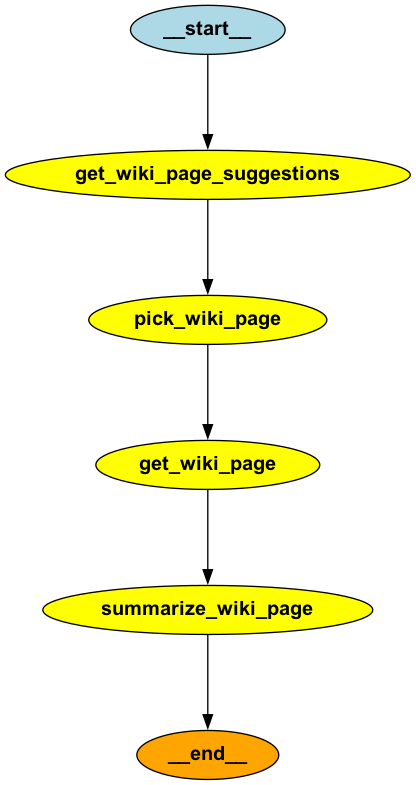

In [31]:
Image(lg_agent.graph.get_graph().draw_png())


In [32]:
# Configuration with thread ID for checkpointing
config = {"configurable": {"thread_id": "profile-thread-1"}}
# initial state
state = WikiAgentState(company="Tesla", symbol="TSLA")
lg_agent.run(config, state)


-1 {}
0 {'company': 'Tesla', 'symbol': 'TSLA'}
1 {'company': 'Tesla', 'symbol': 'TSLA', 'wiki_search_results': ['Tesla, Inc.', "Elon Musk's Tesla Roadster", 'Tesla Powerwall', 'History of Tesla, Inc.', 'Tesla Semi', 'Tesla Model 3', 'TSLA', 'Tesla Autopilot', 'Tesla Fremont Factory', 'Tesla Model X'], 'wiki_page_title': None, 'wiki_page_text': None, 'wiki_page_summary': None, 'error_state': None}
2 {'company': 'Tesla', 'symbol': 'TSLA', 'wiki_search_results': ['Tesla, Inc.', "Elon Musk's Tesla Roadster", 'Tesla Powerwall', 'History of Tesla, Inc.', 'Tesla Semi', 'Tesla Model 3', 'TSLA', 'Tesla Autopilot', 'Tesla Fremont Factory', 'Tesla Model X'], 'wiki_page_title': 'Tesla, Inc.', 'wiki_page_text': None, 'wiki_page_summary': None, 'error_state': None}
3 {'company': 'Tesla', 'symbol': 'TSLA', 'wiki_search_results': ['Tesla, Inc.', "Elon Musk's Tesla Roadster", 'Tesla Powerwall', 'History of Tesla, Inc.', 'Tesla Semi', 'Tesla Model 3', 'TSLA', 'Tesla Autopilot', 'Tesla Fremont Factory', 

### Company Profile

Tesla, Inc. is an American multinational corporation specializing in electric vehicles (EVs) and clean energy solutions, headquartered in Austin, Texas. Founded in July 2003 by Martin Eberhard and Marc Tarpenning, Tesla was named in honor of inventor Nikola Tesla. Elon Musk joined the company as its largest shareholder in February 2004 and became CEO in 2008. Over the years, Tesla has expanded its product lineup to include the Roadster sports car (2008), Model S sedan (2012), Model X SUV (2015), Model 3 sedan (2017), Model Y crossover (2020), Tesla Semi truck (2022), and Cybertruck (2023). The Model 3 has notably become the all-time bestselling plug-in electric car globally, achieving over 1 million units sold by June 2021. In 2023, the Model Y became the best-selling vehicle worldwide.

Tesla, a pioneer in the battery electric vehicle market, held a 19.9% market share in 2023. It has also ventured into energy storage solutions, launching products like Powerwall an

In [33]:
with open(f"{DOWNLOAD_DIR}/wiki_summary.txt", "r") as infile:
    display(Markdown(infile.read()))

### Company Profile

Tesla, Inc. is an American multinational corporation specializing in electric vehicles (EVs) and clean energy solutions, headquartered in Austin, Texas. Founded in July 2003 by Martin Eberhard and Marc Tarpenning, Tesla was named in honor of inventor Nikola Tesla. Elon Musk joined the company as its largest shareholder in February 2004 and became CEO in 2008. Over the years, Tesla has expanded its product lineup to include the Roadster sports car (2008), Model S sedan (2012), Model X SUV (2015), Model 3 sedan (2017), Model Y crossover (2020), Tesla Semi truck (2022), and Cybertruck (2023). The Model 3 has notably become the all-time bestselling plug-in electric car globally, achieving over 1 million units sold by June 2021. In 2023, the Model Y became the best-selling vehicle worldwide.

Tesla, a pioneer in the battery electric vehicle market, held a 19.9% market share in 2023. It has also ventured into energy storage solutions, launching products like Powerwall and Powerpack. The company is known for its vertical integration, developing many components in-house, including batteries, motors, and software. As of March 2024, Tesla is ranked 69th in the Forbes Global 2000 and is the world's most valuable automaker.

### Products and Services

#### Vehicle Models
1. **Model S**: A full-size luxury sedan with dual motor all-wheel drive. Initially launched in 2012, it has undergone major design refreshes in 2016 and 2021.
2. **Model X**: A mid-size luxury SUV with unique "falcon-wing" doors, launched in 2015. It shares about 30% of its parts with the Model S.
3. **Model 3**: A mid-size, more affordable sedan launched in 2017, with cumulative sales surpassing 1 million units by June 2021.
4. **Model Y**: A mid-size crossover SUV that shares 75% of its components with the Model 3. It became the world's best-selling car in Q1 2023.
5. **Tesla Semi**: A Class 8 semi-truck with a tri-motor layout and an estimated range of 500 miles. Initial deliveries began in December 2022.
6. **Cybertruck**: A full-sized pickup truck with a polarizing stainless steel exterior, launched in November 2023.

#### Energy Products
- **Powerwall**: A home energy storage device.
- **Megapack**: A large-scale energy storage system.
- **Solar Products**: Including solar panels and the Tesla Solar Roof.

#### Services
- **Charging Services**: Tesla operates a Supercharger network for fast charging and a Destination Charging network for slower, more prolonged charging.
- **Insurance Services**: Tesla offers vehicle insurance in specific U.S. states, leveraging unique data from its vehicles.

### Strategic Initiatives

1. **Partnerships and Collaborations**: Tesla has significant partnerships with companies like Panasonic for battery cell production and has long-term contracts for lithium supply with companies like Piedmont Lithium.
2. **Global Expansion**: New Gigafactories have been built in Shanghai, Berlin, and Texas, with plans for a Gigafactory in Mexico by 2025.
3. **Technological Advancements**: Tesla has developed its own battery cells (4680-type) and extensively uses over-the-air software updates to enhance vehicle features.
4. **Vertical Integration**: Tesla's strategy involves developing many components in-house, reducing reliance on suppliers and enhancing control over manufacturing processes.

### Recent Events

1. **Corporate Moves**: In December 2021, Tesla moved its legal headquarters to Texas but continued to expand its footprint in California. In 2023, it announced a new global engineering headquarters in Palo Alto.
2. **Financial Performance**: Tesla reported significant growth in vehicle deliveries, achieving 1.8 million units in 2023. It also experienced a 38% increase in deliveries from the previous year.
3. **Regulatory and Legal Issues**: Tesla has been involved in several lawsuits and regulatory investigations, including issues related to Autopilot crashes, labor disputes, and environmental violations.
4. **Strategic Shifts**: In 2024, Tesla announced the abandonment of its next-generation gigacasting technique, opting for a more proven method of casting vehicle underbodies.
5. **New Approvals**: Tesla's Full Self-Driving (FSD) software was approved in China in late April 2024, opening new market opportunities.

### Conclusion

Tesla has achieved substantial milestones in both the automotive and clean energy sectors. Its vertical integration, innovative products, and strategic global expansion have positioned it as a market leader. However, ongoing legal and regulatory challenges, as well as the need to maintain production efficiency and product safety, remain critical areas for investors to monitor.